# Project Title – Predicting Drug Mechanism of Action using Chemical Fingerprinting

## IntroductionComputational chemistry is an emerging field in drug discovery that leverages advanced computational methods to better understand how compounds interact with biological systems. This paper will address some of the limitations of the drug discovery process and how computational chemistry can be used to overcome them. Using data from the Broad Repurposing Hub, the applicability of these techniques will be demonstrated by developing a predictive model to classify drugs by their mechanism of action (MOA) using structural data from the National Library of Medicine. Lastly, the model will be applied to a novel set of experimental compounds to uncover new insights into their mechanisms of action.

## Similar Structure, Similar Function

Computational chemistry has emerged as a powerful tool for researchers to identify new drug candidates and new uses for existing drugs. The principle of “similar structure, similar function” postulates that drugs with similar chemical structures will exhibit similar biological activities. Leveraging this principle, scientists aim to identify quantitative structure-activity relationships (QSAR). QSAR models establish associations between chemical structures and their corresponding biological responses.
By analyzing these relationships, researchers can develop robust models capable of predicting the biological effects of compounds that have not yet been evaluated in the lab. These predictive models are invaluable in the early stages of drug discovery, as they allow scientists to screen vast libraries of compounds efficiently, focusing experimental efforts on the most promising candidates. The integration of computational chemistry and QSAR models accelerates the drug discovery process, reduces costs, and enhances the likelihood of finding effective therapies.

In this study, I will use chemical fingerprinting trained on the Broad Repurposing data set to predict drug mechanisms of act and protein targetsion. The resulting model will be applied to compounds found in the Fibraurea tinctoria plant to explore potential therapeutic uses.




In [3]:
# Set Working Directory
#import os
#os.chdir('C:/Users/Lenovo/OneDrive/Documents/CMD 4200/Phenotypic Modeling')

# Imports

import matplotlib.pyplot as plt
from matplotlib import colormaps

import random
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import (label_binarize, LabelEncoder)
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

from sklearn.utils import resample

# Custom function for extracting pubchem fingerprints
from getFPfromCID import getFPfromCID



## Data Sources

### PubChem Fingerprints

PubChem Chemical Fingerprints were obtained through the [PUG-REST](https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest) API provided by the National Library of Medicine, using the PubChem Compound IDs from the Broad data set. These fingerprints consist of 881-bit binary vectors, where each bit corresponds to the presence or absence of a specific chemical motif. To enhance the model's efficiency and accuracy, zero variance bits were excluded, resulting in 695 unique predictors.

In [5]:
#fingerprints = getFPfromCID(compounds.pubchem_cid.unique())
#fingerprints.to_csv('fingerprints.csv')

# Fingerprints were save to csv to reduce load on Pubchem API, but can be obtained with getFPfromCID fucntion
fingerprints = pd.read_csv('fingerprints2.csv', index_col = 0)
fingerprints = fingerprints.loc[:, fingerprints.var()>0] # Remove zero variance predictors
fingerprints.head()

,>= 4 H,>= 8 H,>= 16 H,>= 32 H,>= 1 B,>= 2 C,>= 4 C,>= 8 C,>= 16 C,>= 32 C,...,SC1CC(N)CC1,NC1CC(N)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(N)CCC1,NC1C(N)CCC1
6005,1,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
448055,1,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6918881,1,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
158758,1,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
163829,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### The Broad Repurposing Hub 
he [Broad Drug Repurposing Hub is a comprehensive repository that contains detailed profiles of FDA-approved drugs, clinical candidates, and pre-clinical experimental compounds. Each compound is annotated with a single mechanism of action (MOA) and known protein targets. To ensure that the model was adequately powered, MOA classeand protein targets with fewer than twenty observations were excluded from the analysid.

In [7]:
# This file serves key to convert PubChem CID identifiers to their equivalent Broad ID. Current and depracated IDs are merged to increase matches.
compounds = pd.read_table('https://storage.googleapis.com/cdot-general-storage/repurposing_samples_20240610.txt', skiprows = 9).dropna(subset = 'pubchem_cid')
compounds['pubchem_cid'] = compounds['pubchem_cid'].astype(int)

# This file contains information about mechanism of action and targets
treatment = pd.read_table('https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_drugs_20200324.txt', skiprows = 9)

# Inner merge to filte for only matching 
BroadChems = pd.merge(compounds, treatment, on = 'pert_iname', how = 'inner').drop_duplicates(subset = 'pubchem_cid')
BroadChems.columns = BroadChems.columns.str.upper()
BroadChems.index = BroadChems.PUBCHEM_CID

# Mechaism of action with more than 20 observations
topMoa = pd.DataFrame({'COUNT' : BroadChems.groupby(['MOA']).size().sort_values(ascending = False)})
topMoa = topMoa[topMoa.COUNT>20]
topMoa.head()

,COUNT
MOA,
adrenergic receptor antagonist,101
cyclooxygenase inhibitor,100
bacterial cell wall synthesis inhibitor,84
adrenergic receptor agonist,83
glutamate receptor antagonist,75


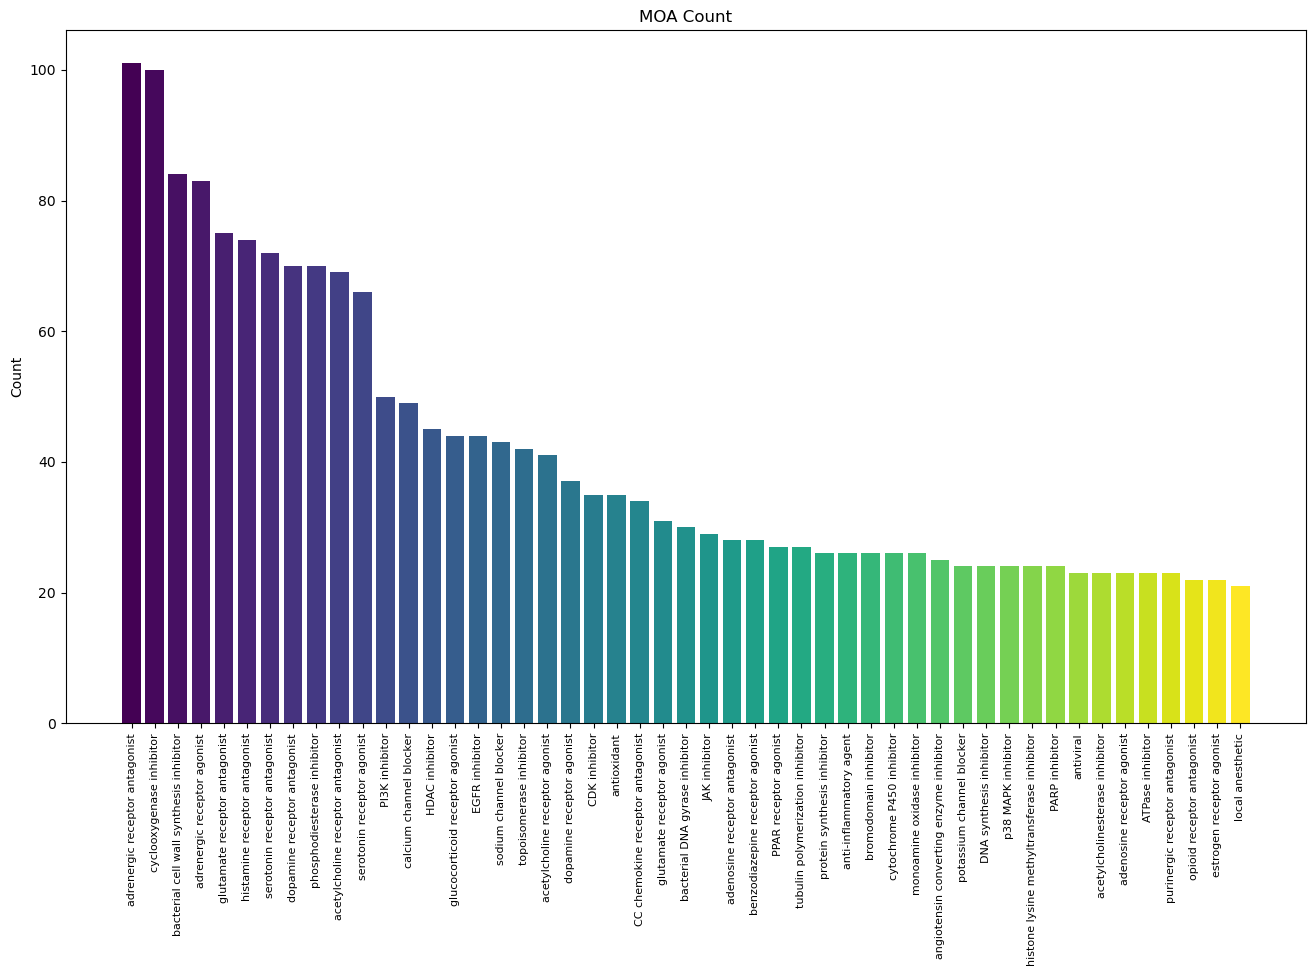

In [8]:
cmap = colormaps['viridis']

# colormap for MOA Data
col1 = cmap(np.linspace(0, 1, len(set(topMoa.index))))

# Target Variables by Count

plt.figure(figsize=(16,9))
plt.bar(topMoa.index, topMoa.COUNT, color = col1)

plt.ylabel("Count")
plt.title("MOA Count")
plt.tick_params(axis='x', labelrotation=90, labelsize = 8)
plt.show()

In [9]:
# combine fingerprint data with MOA Data
fpData = BroadChems.join(fingerprints, how = 'inner').drop_duplicates(subset = 'PUBCHEM_CID')

# Filter data to inclucde MOAs with 20 or more observations and include only fingerprints as predictors
modelData = fpData.loc[fpData.MOA.isin(topMoa.index), fpData.columns.isin(fingerprints.columns)]

# include only MOAs wit 20 or more observations
modelTarget = fpData.MOA[fpData.MOA.isin(topMoa.index)]

# split the model into training and testing set
X_train, X_test, y_train, y_test = train_test_split(modelData, modelTarget, test_size=0.3)
X_train.head()

,>= 4 H,>= 8 H,>= 16 H,>= 32 H,>= 1 B,>= 2 C,>= 4 C,>= 8 C,>= 16 C,>= 32 C,...,SC1CC(N)CC1,NC1CC(N)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(N)CCC1,NC1C(N)CCC1
56962337,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3073499,1,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7048578,1,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
91754520,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
110635,1,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
geneData = fpData.copy()

# for cmompound with multiple targets, split by seperator and expand
geneData['TARGET'] = geneData['TARGET'].str.split('|')
geneData = geneData.explode('TARGET').dropna(subset = 'TARGET')

# Select targets with more than 20 observations
commonTargets = geneData.groupby('TARGET').size()
commonTargets = pd.DataFrame({'COUNT': commonTargets[commonTargets>20]}).sort_values('COUNT', ascending=False)

# Include only targets with 20 values
geneModel = geneData.loc[geneData.TARGET.isin(commonTargets.index), fingerprints.columns]
geneTargets = geneData.TARGET[geneData.TARGET.isin(commonTargets.index)]

commonTargets.head()

,COUNT
TARGET,
HTR2A,132
DRD2,124
HTR1A,119
ADRA1A,97
HRH1,96


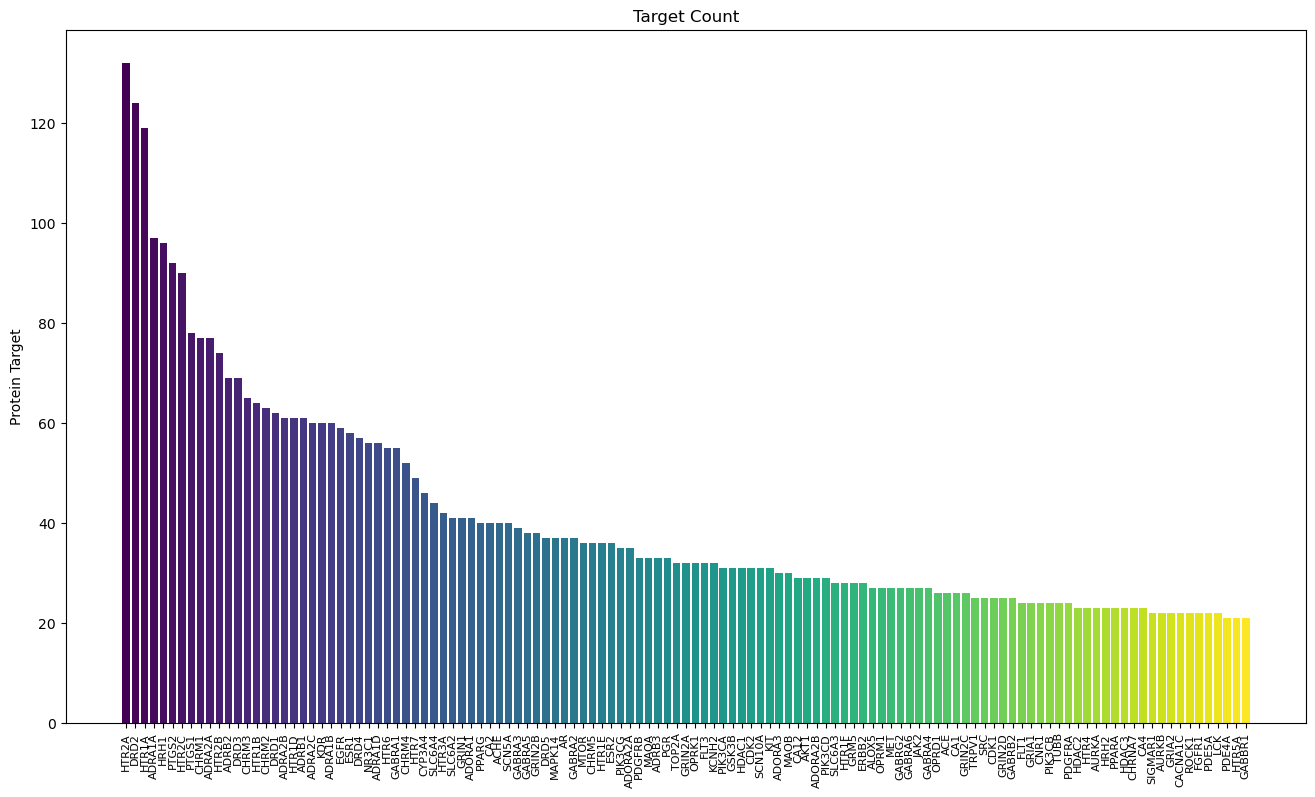

In [11]:
# Colormap for top target counts
col2 = cmap(np.linspace(0, 1, len(commonTargets.index)))
plt.figure(figsize=(16,9))
plt.bar(commonTargets.index, commonTargets.COUNT, color = col2)

plt.ylabel("Count")
plt.ylabel("Protein Target")
plt.title("Target Count")
plt.tick_params(axis='x', labelrotation=90, labelsize = 8)


### Unsupervised k-nearest Neighbor Clustering

Unsupervised k-nearest neighbor (k-NN) clustering was applied to the top MOA subclasses to explore patterns within the data. To visualize the clustering results, the predictors were reduced to two principal components, which served as plot coordinates.

### Support Vector Classifier

Support Vector Classifier (SVC) modeling was applied to the data set using a one-vs-rest strategy. This approach manages multi-class classification problems by utilizing binary classifiers. It works by fitting one classifier per class, where each classifier is trained to distinguish that class from all other classe1.
The data were split into 70% for training and 30% for testing. To evaluate the model's performance, ROC curves and AUC values were calculated individually for each class. Additionally, a micro-average ROC and AUC were calculated to summarize the overall performance of the model across all class.se

### Metric of Assessment
Area Under the Receiver Operating Characteristic Curve (AUROC) was chosen as the appropriate method for evaluating the model.  Unlike accuracy, which depends on a specific threshold for classification, AUROC evaluates the model's performance across all possible classification thresholds. This provides a more comprehensive assessment of the model's ability to distinguish between classes, irrespective of the chosen decision threshold.  This is extremely valuable for multiclass data where there are many imbalanced clas.
s.


## Results

The figure below displays the results from the unsupervised clustering algorithm. For clarity, only the top eight most common mechanisms of action are included in the figure. Each dot is colored by its respective cluster and each label is colored by its respective mechanism of action. Data points where the color of the dot does not match the color of the label indicate compounds that are structurally dissimilar from other compounds of the same class. In general, compound structure aligned with mechanism of action, although significant overlap was observed between all classes.

### Unsupervised Clustering

The figure below displays the results from the unsupervised clustering algorithm. For clarity, only the top eight most common mechanisms of action are included in the figure. Each dot is colored by its respective cluster and each label is colored by its respective mechanism of action. Data points where the color of the dot does not match the color of the label indicate compounds that are structurally dissimilar from other compounds of the same class. In general, compound structure aligned with mechanism of action, although significant overlap was observed between all classes.

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


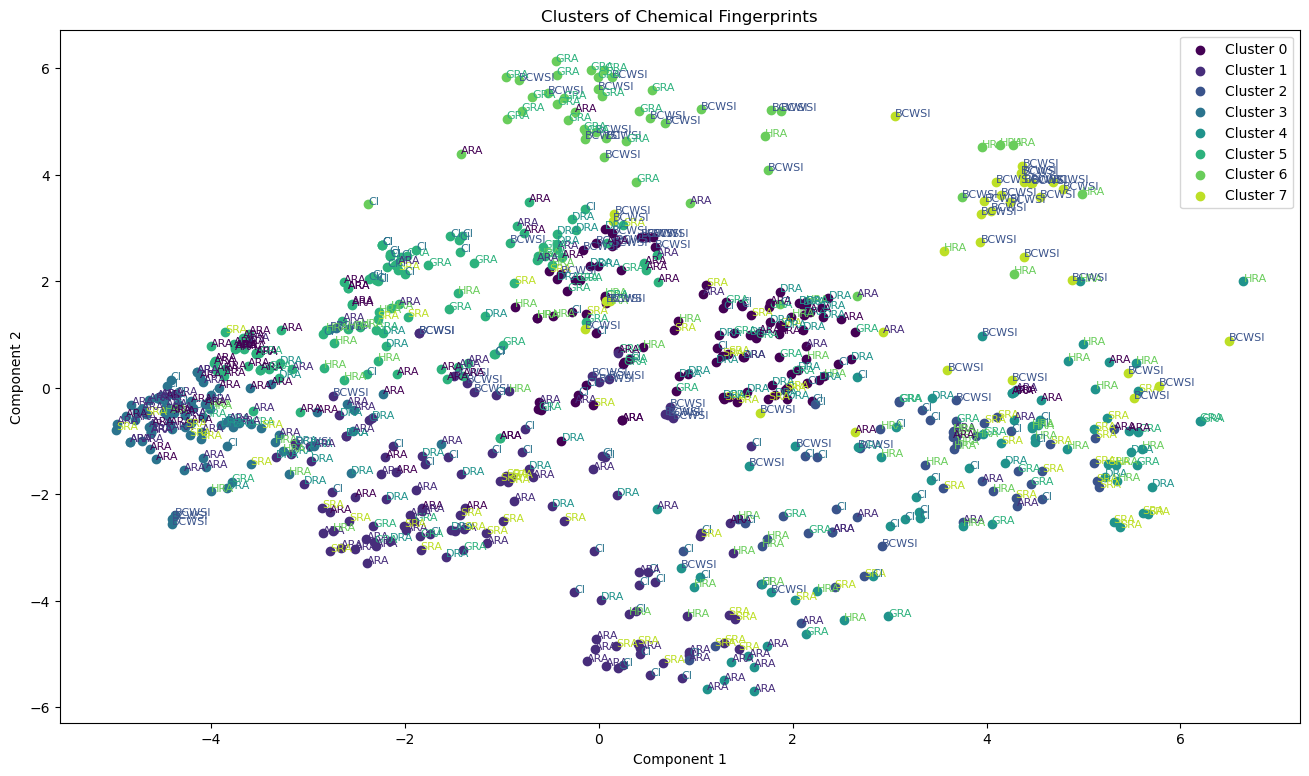

In [16]:

# so that the graph isn't so clustered i only included 8 MOAs
plotData =  fpData.loc[fpData.MOA.isin(topMoa.index[0:8]), fpData.columns.isin(fingerprints.columns)]
plotTarget = fpData.MOA[fpData.MOA.isin(topMoa.index[0:8])]

# create name abbreviations from the caplitalized first letter of each MOA
abbr={}
for i, v in  enumerate(plotTarget):
    abbr[v] = "".join(list(map(lambda x: x[0].upper(), v.split(" "))))

# cluster with the number of cluster set to the number of MOAs
kmeans = KMeans(n_clusters=len(np.unique(plotTarget.values)))
clusters = kmeans.fit_predict(plotData)

# reduce data to 2 principal components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(plotData)

#color map
col = cmap(np.linspace(0, 0.9, len(np.unique(clusters))))

plt.figure(figsize=(16,9))
for i in range(len(np.unique(clusters))):
    cluster_points = reduced_data[clusters == i]
    plt.scatter(reduced_data[clusters == i, 0], reduced_data[clusters == i, 1], label=f'Cluster {i}', color = col[i]) #set color based on cluster

    for j, point in enumerate(cluster_points):
        idx = np.where((reduced_data == point).all(axis=1))[0][0]
        plt.annotate(abbr[plotTarget.values[idx]], (point[0], point[1]), fontsize =8, \
                     color = col[np.where(np.unique(plotTarget.values) == plotTarget.values[idx])[0]]) # set color based on class
        
plt.title('Clusters of Chemical Fingerprints')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [17]:
from IPython.display import display, Markdown
display(Markdown(f'Clustering of compounds by Chemical Fingerprints of the top 8 mechansims.  Labels correspond to the drug Mechanism of action {", ".join(list(" = ".join(i) for i in abbr.items()))}'))

Clustering of compounds by Chemical Fingerprints of the top 10 mechansims.  Labels correspond to the drug Mechanism of action glutamate receptor antagonist = GRA, adrenergic receptor agonist = ARA, dopamine receptor antagonist = DRA, serotonin receptor antagonist = SRA, histamine receptor antagonist = HRA, adrenergic receptor antagonist = ARA, cyclooxygenase inhibitor = CI, bacterial cell wall synthesis inhibitor = BCWSI

### Mechanism of Action Classification

Support Vector Machine classification modeling was applied to the test data set to predict mechanism of action.
AUROC (Area Under the Receiver Operating Characteristic Curve) was used as the preferred method to evaluate the model. An aggregate ROC curve was produced using micro-averaged One-vs-Rest strategy. ROC curves for each of the MOA classes and the micro-averaged values are shown in figure 4. AUROC varied significantly depending on the MOA, ranging from 0.374 to 0.948.  Overall, the model exhibited strong predictive performance with a composite micro-averaged AUROC of 0.88.


In [19]:

# Binarize the training Endpoint
le = LabelEncoder() 
label_train = le.fit_transform(y_train) 
yInt = label_binarize(label_train, classes=range(len(topMoa))) 

# binarize tesing Enpoints
label_test = le.fit_transform(y_test)
yIntTest = label_binarize(label_test, classes=range(len(topMoa))) 

# Perform SVM classification and predict test set
MOAmodel = OneVsRestClassifier(svm.SVC(probability=True, random_state = 10))
MOAmodel.fit(X_train, yInt)
y_probs = MOAmodel.predict_proba(X_test)

# canculate the roc and auc following the micro-average example : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(topMoa)):
    fpr[i], tpr[i], _ = roc_curve(yIntTest[:, i], y_probs[:, i])
    roc_auc[topMoa.index[i]] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yIntTest.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

pd.DataFrame({'auroc' : roc_auc}).sort_values(by = 'auroc', ascending = False).head()

,auroc
antioxidant,0.997555
protein synthesis inhibitor,0.989506
glucocorticoid receptor agonist,0.985833
serotonin receptor antagonist,0.983994
anti-inflammatory agent,0.983192


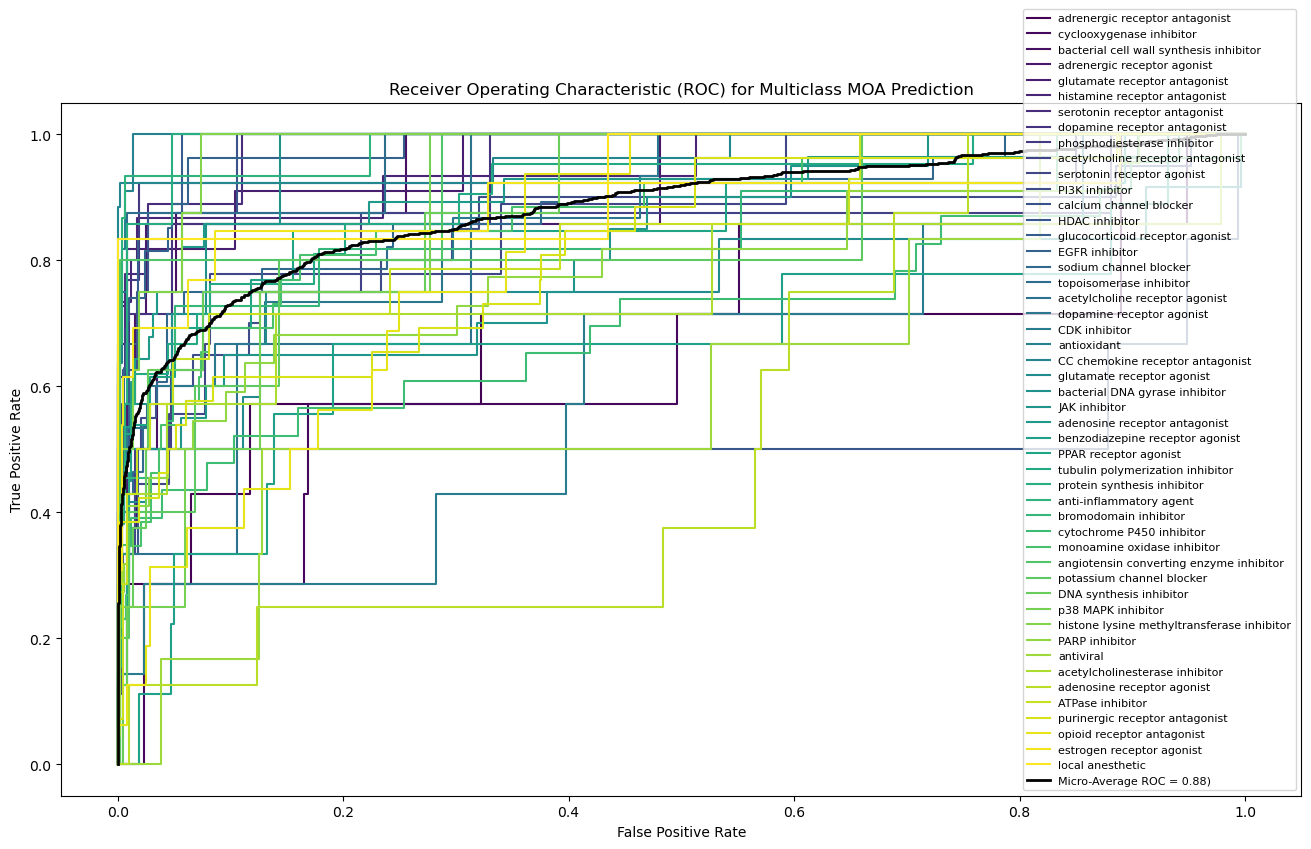

In [20]:
# Plot ROC curve for each class and the micro-average ROC curve
cmap = colormaps['viridis']
plt.figure(figsize = (16,9))
colors = cmap(np.linspace(0, 1, len(topMoa)))

for i in range(len(topMoa)):
    plt.plot(fpr[i], tpr[i], color=colors[i], 
             label=topMoa.index[i])

plt.plot(fpr["micro"], tpr["micro"], color='black', linewidth=2,
         label=f'Micro-Average ROC = {roc_auc["micro"]:0.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass MOA Prediction')
plt.legend(loc="lower right", fontsize = 8)
plt.show()


Class predictions were assigned based on the class with the highest probability score. The model exhibited an overall accuracy of 0.49, correctly predicting the mechanism of a drug’s action 49% of the time. Recall and precision were estimated at 0.47 and 0.45 respectively, resulting in an F1-Score of 0.44.  A confusion matrix comparing the observed versus expected results is provided below.

Text(170.7222222222222, 0.5, 'Expected')

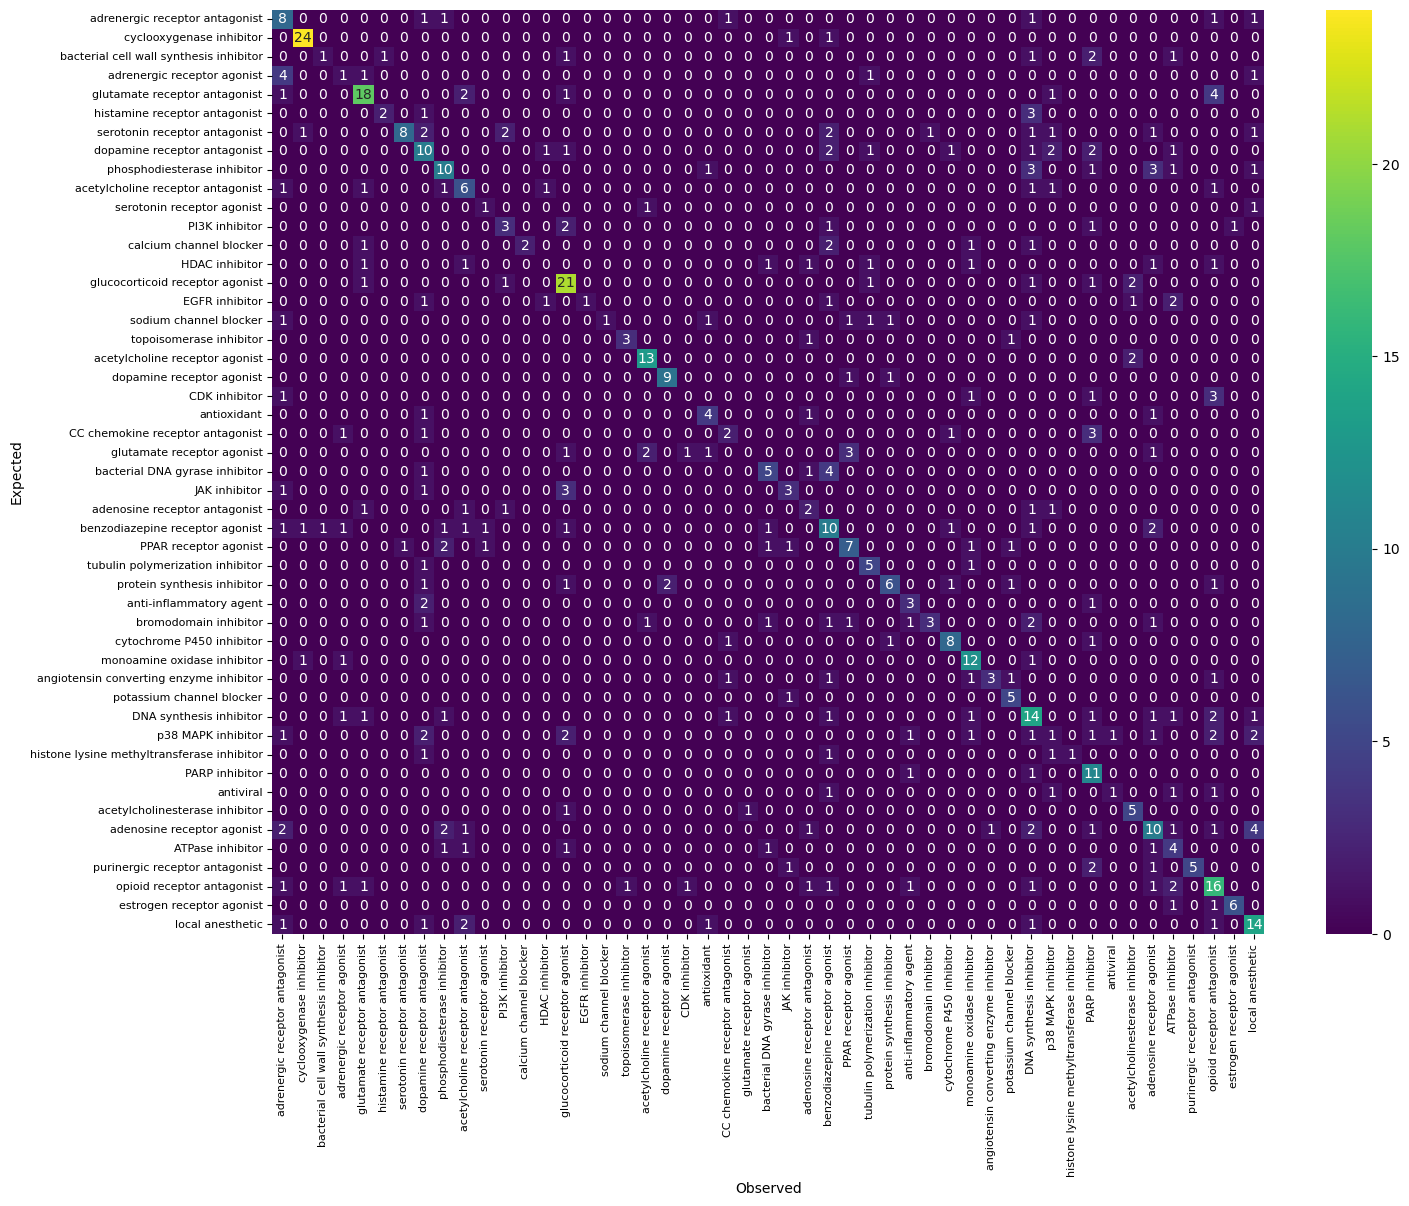

In [22]:

#{topMoa.index[label_test[x]]
confidence = pd.DataFrame({'actual' : topMoa.index[label_test].values, 
                           'highest_prop': list(map(lambda x: topMoa.index[np.where(x == x.max())][0], y_probs)), # calculate higets prob class
                            'prop_actual' : list(map(lambda x: y_probs[x][label_test[x]], np.arange(len(y_probs)))) #calculate the prob of true class
                          })


# Conflusion Matrix
conf_matrix = confusion_matrix(confidence.actual, confidence.highest_prop)
confusion_df = pd.DataFrame(conf_matrix, index = topMoa.index, columns = topMoa.index)
fig, ax = plt.subplots(figsize=(16,12))    
axes = sns.heatmap(confusion_df, annot = True, cmap = 'viridis')

ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xlabel('Observed')
ax.set_ylabel('Expected')

In [23]:
#MOA Classification Report

print(f"Classification Report:\n{classification_report(confidence.actual, confidence.highest_prop)}")

Classification Report:
                                            precision    recall  f1-score   support

                          ATPase inhibitor       0.35      0.57      0.43        14
          CC chemokine receptor antagonist       0.89      0.92      0.91        26
                             CDK inhibitor       0.50      0.14      0.22         7
                   DNA synthesis inhibitor       0.17      0.12      0.14         8
                            EGFR inhibitor       0.69      0.67      0.68        27
                            HDAC inhibitor       0.67      0.33      0.44         6
                             JAK inhibitor       0.89      0.40      0.55        20
                            PARP inhibitor       0.36      0.45      0.40        22
                            PI3K inhibitor       0.53      0.50      0.51        20
                     PPAR receptor agonist       0.40      0.46      0.43        13
            acetylcholine receptor agonist       0.3

### Protein Target Classification

Support Vector Machine classification modeling was applied to the test data set to predict protein targets. AUROC (Area Under the Receiver Operating Characteristic Curve) was used as the preferred method to evaluate the model. An aggregate ROC curve was produced using micro-averaged One-vs-Rest strategy. ROC curves for each of the MOA classes and the micro-averaged values are shown below. The model was less sucessful at predicting protein targets compared to MOA predictions.  Overall, the model exhibited modest predictive performance with a composite micro-averaged AUROC of 0.75.


In [25]:
# split data
X_train, X_test, y_train, y_test = train_test_split(geneModel, geneTargets, test_size=0.3)
X_train.head()
# Binarize the training Endpoint

le = LabelEncoder() 
label_train = le.fit_transform(y_train) 
yInt = label_binarize(label_train, classes=range(len(commonTargets)))  # Adjust the number of classes as needed

# Binarize the testing Endpoint

label_test = le.fit_transform(y_test)
yIntTest = label_binarize(label_test, classes=range(len(commonTargets))) 

# SVM Classifier
geneModel = OneVsRestClassifier(svm.SVC(probability=True, random_state=10))
geneModel.fit(X_train, yInt)

y_probs = geneModel.predict_proba(X_test)

# canculate the roc and auc following the micro-average example : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(commonTargets)):
    fpr[i], tpr[i], _ = roc_curve(yIntTest[:, i], y_probs[:, i])
    roc_auc[commonTargets.index[i]] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yIntTest.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

pd.DataFrame({'auroc' : roc_auc}).sort_values(by = 'auroc', ascending = False).head()

,auroc
HTR2A,0.999663
CDK1,0.990704
GABRA5,0.967426
GABRA3,0.961060
KCNH2,0.959177


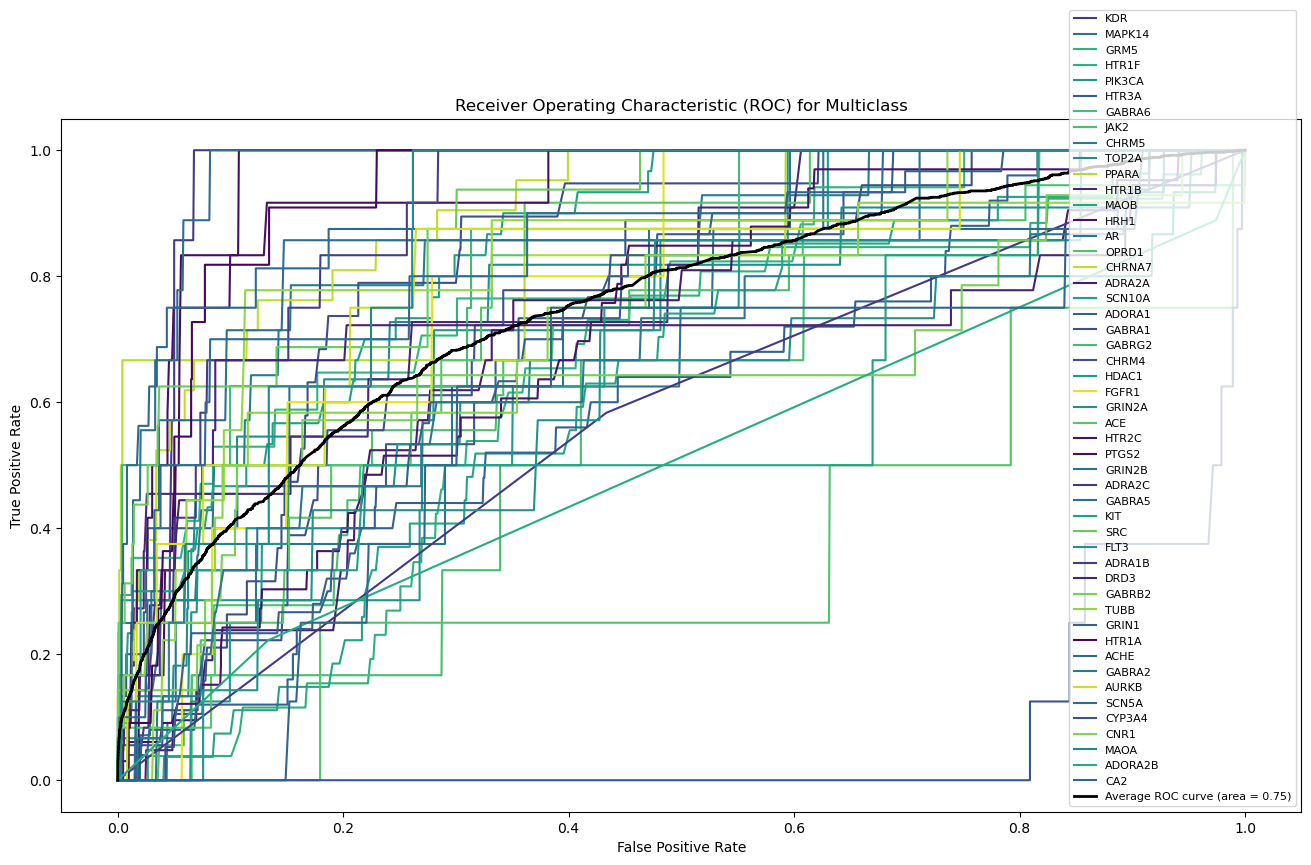

In [26]:

# Plot ROC curve for each class and the micro-average ROC curve
cmap = colormaps['viridis']
plt.figure(figsize = (16,9))
colors = cmap(np.linspace(0, 1, len(commonTargets)))


for i in random.sample(range(len(commonTargets)), 50):
    plt.plot(fpr[i], tpr[i], color=colors[i], 
             label=commonTargets.index[i])

plt.plot(fpr["micro"], tpr["micro"], color='black', linewidth=2, label='Average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass')
plt.legend(loc="lower right", fontsize = 8)
plt.show()


In [27]:
print(f"Classification Report:\n{classification_report(confidence.actual, confidence.highest_prop)}")

Classification Report:
                                            precision    recall  f1-score   support

                          ATPase inhibitor       0.35      0.57      0.43        14
          CC chemokine receptor antagonist       0.89      0.92      0.91        26
                             CDK inhibitor       0.50      0.14      0.22         7
                   DNA synthesis inhibitor       0.17      0.12      0.14         8
                            EGFR inhibitor       0.69      0.67      0.68        27
                            HDAC inhibitor       0.67      0.33      0.44         6
                             JAK inhibitor       0.89      0.40      0.55        20
                            PARP inhibitor       0.36      0.45      0.40        22
                            PI3K inhibitor       0.53      0.50      0.51        20
                     PPAR receptor agonist       0.40      0.46      0.43        13
            acetylcholine receptor agonist       0.3

## Conclusions

This study focused on developing a support vector machine (SVM) classifier using PubChem fingerprints to predict drug mechanisms of action (MOA) within the Broad Repurposing dataset. Despite the straightforward concept, few publications address this specific question directly.  The Dialogue on Reverse Engineering Assessment and Methods (DREAM) challenges, which are crowdsourced competitions to solve real world problems using data science, have proposed similar questions multiple times. For example, the IDG-DREAM Challenge challenged participants to predict drug targets from chemical fingerprints, but data were limited to kinase inhibitors, excluding the broader drug classes considered hee2. The AZ-DREAM Challenge used chemical fingerprints to predict drug synergy when a drug was paired with another compound of a known drug class.  The PANACEA DREAM Challenge asked participants to predict the same drug classes used here, but with gene expression and cell viability data instead of chemical fingerprins.3
.
One unreviewed publication that used chemical fingerprints to predict drug MOAs using the Broad Repurposing Hub found no predictive value in chemical fingerprinting (AUROC = 0.47 and 0.43), identifying gene dependency metrics as stronger predictor12. In contrast, the model developed in this study showed strong predictive value (AUROC = 0.89). Possible explanations for these discrepancies include selection bias, as this study excluded MOA classes with fewer than twenty observations, potentially explaining the performance differene

s.
### Novel Targets 

In June 2022, researchers at Gunung Leuser National Park in Sumatra, Indonesia, made a groundbreaking observation by recording a Sumatran orangutan named Rakus self-medicating with a paste made from Fibraurea tinctoria to heal a large wound on his cheek. This marks the first documented instance of a wild animal using a medicinal plant to treat an injry4. Fibraurea tinctoria, also known as Akar Kuning, is used in Indonesian folk medicine for treating malaria and diabetes. However, no major clinical trials have been conducted to verify these uses. Limited research has shown that the primary alkaloids, called berberines, exhibit anti-inflammatory and antimicrobial properties, but little else is known about the plant's fulltential.
5
.
When applying the model developed here to thirteen compounds foun nd iPubChem [AID 311859](https://pubchem.ncbi.nlm.nih.gov/bioassay/3119)ia, Makisterone A, and hormone usually found in insects, aligned modestly with anti-inflammatory compoun and compounds that target CDK1et. For researchers interested in studying the medicinal properties of Fibraurea tinctoria, experiments like this could save scientist valuable resources.  Instead of screening all thirteen compounds, researchers can focus on the molecules, such as Makisterone A, that are most likely to be successful. While little is known about the effects of Makisterone A, it seems pausible that this compound may play a role in the medicinal effects observed when Rakus applied the Fibraurea tinctoria paste to his fwound.
n
d.
In conclusion, this study demonstrates the potential of computational chemistry in early-stage drug development, showing that chemical fingerprints can predict certain drug MOAs. This study presents a promising approach to drug discovery using computational methods to identify new therapies and novel applications for exis drugs.1859)

In [29]:
# exttracts from Fibraurea tinctoria
extracts = [73442,24762429,24762502,24762503,24762504,44445723,44445724,44445725,12312690,72323,72310,10358881,3823]

extractsFP = getFPfromCID(extracts)
extractsFP.head()

,>= 4 H,>= 8 H,>= 16 H,>= 32 H,>= 1 Li,>= 2 Li,>= 1 B,>= 2 B,>= 4 B,>= 2 C,...,SC1C(S)CCC1,SC1C(N)CCC1,SC1C(Cl)CCC1,SC1C(Br)CCC1,NC1C(N)CCC1,NC1C(Cl)CC1,NC1C(Br)CCC1,ClC1C(Cl)CCC1,ClC1C(Br)CCC1,BrC1C(Br)CCC1
73442,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24762429,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24762502,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24762503,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24762504,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Fibraurea tinctoria Predictions - MOA


In [31]:
# probability of each MOA for each compound
MOApred = MOAmodel.predict_proba(extractsFP.loc[:, X_test.columns])
MOApredDF= pd.DataFrame(MOApred.T)
MOApredDF.index = topMoa.index
MOApredDF.columns = extracts
MOApredDF.sort_values(by = 12312690, ascending = False).head()

,73442,24762429,24762502,24762503,24762504,44445723,44445724,44445725,12312690,72323,72310,10358881,3823
MOA,,,,,,,,,,,,,
anti-inflammatory agent,0.001581,0.002506,0.002814,0.002814,0.001258,0.152376,0.002386,0.002155,0.345756,0.001529,0.001529,0.001529,0.001776
adrenergic receptor antagonist,0.005515,0.048994,0.081211,0.081211,0.046917,0.061025,0.034661,0.027720,0.042564,0.004945,0.004945,0.004945,0.003987
serotonin receptor antagonist,0.009289,0.011951,0.009968,0.009968,0.012364,0.023439,0.011713,0.011646,0.031120,0.012368,0.012368,0.012368,0.003868
benzodiazepine receptor agonist,0.011821,0.018634,0.008615,0.008615,0.011943,0.018091,0.009273,0.011906,0.024501,0.020590,0.020590,0.020590,0.346895
dopamine receptor antagonist,0.002368,0.005967,0.008041,0.008041,0.003922,0.011179,0.008940,0.007132,0.021803,0.003512,0.003512,0.003512,0.000314


### Fibraurea tinctoria Predictions - Targets

In [33]:
# probability of each Target for each compound
targetpred = geneModel.predict_proba(extractsFP.loc[:, X_test.columns])
targetpredDF= pd.DataFrame(targetpred.T)
targetpredDF.index = commonTargets.index
targetpredDF.columns = extracts
targetpredDF.sort_values(by = 12312690, ascending = False).head()

,73442,24762429,24762502,24762503,24762504,44445723,44445724,44445725,12312690,72323,72310,10358881,3823
TARGET,,,,,,,,,,,,,
CDK1,0.001154,0.011373,0.014678,0.014678,0.001711,0.734314,0.008253,0.003028,0.899697,0.001257,0.001257,0.001257,0.001237
PIK3CD,0.025336,0.025416,0.024101,0.024101,0.025642,0.023886,0.024908,0.023565,0.024106,0.025060,0.025060,0.025060,0.026264
ADORA3,0.022078,0.016899,0.024668,0.024668,0.025130,0.026254,0.023344,0.018522,0.023525,0.024682,0.024682,0.024682,0.028038
GABRA3,0.012581,0.009696,0.008154,0.008154,0.013299,0.013101,0.006199,0.008505,0.019923,0.016292,0.016292,0.016292,0.013604
CA4,0.010826,0.019568,0.015784,0.015784,0.016126,0.021409,0.017945,0.017920,0.017560,0.011461,0.011461,0.011461,0.011231


### References

1.	Congressional Budget Office. (2021). Research and Development in the Pharmaceutical Industry. Retrieved from https://www.cbo.gov/publication/57126
2.	Cichońska A, Ravikumar B, Allaway RJ, Wan F, Park S, Isayev O, Li S, Mason M, Lamb A, Tanoli Z, Jeon M, Kim S, Popova M, Capuzzi S, Zeng J, Dang K, Koytiger G, Kang J, Wells CI, Willson TM; IDG-DREAM Drug-Kinase Binding Prediction Challenge Consortium; Oprea TI, Schlessinger A, Drewry DH, Stolovitzky G, Wennerberg K, Guinney J, Aittokallio T. Crowdsourced mapping of unexplored target space of kinase inhibitors. Nat Commun. 2021 Jun 3;12(1):3307. doi: 10.1038/s41467-021-23165-1. PMID: 34083538; PMCID: PMC8175708.
3.	Douglass EF Jr, Allaway RJ, Szalai B, Wang W, Tian T, Fernández-Torras A, Realubit R, Karan C, Zheng S, Pessia A, Tanoli Z, Jafari M, Wan F, Li S, Xiong Y, Duran-Frigola M, Bertoni M, Badia-I-Mompel P, Mateo L, Guitart-Pla O, Chung V; DREAM CTD-squared Pancancer Drug Activity Challenge Consortium; Tang J, Zeng J, Aloy P, Saez-Rodriguez J, Guinney J, Gerhard DS, Califano A. A community challenge for a pancancer drug mechanism of action inference from perturbational profile data. Cell Rep Med. 2022 Jan 18;3(1):100492. doi: 10.1016/j.xcrm.2021.100492. PMID: 35106508; PMCID: PMC8784774.
4.	Laumer IB, Rahman A, Rahmaeti T, Azhari U, Hermansyah, Atmoko SSU, Schuppli C. Active self-treatment of a facial wound with a biologically active plant by a male Sumatran orangutan. Sci Rep. 2024 May 2;14(1):8932. doi: 10.1038/s41598-024-58988-7. PMID: 38698007; PMCID: PMC11066025.
5.	Liu M, Srivastava G, Ramanujam J, Brylinski M. Augmented drug combination dataset to improve the performance of machine learning models predicting synergistic anticancer effects. Reint]. 2023 Oct 28:rs.3.rs-3481858. doi: 10.21203/rs.3.rs-3481858/v1. Update in: Sci Rep. 2024 Jan 18;14(1):1668. doi: 10.1038/s41598-024-51940-9. PMID: 37961281; PMCID: PMC10635365.
6.	Mohs RC, Greig NH. Drug discovery and development: Role of basic biological research. Alzheimers Dement (N Y). 2017 Nov 11;3(4):651-657. doi: 10.1016/j.trci.2017.10.005. PMID: 29255791; PMCID: PMC5725284.
7.	Patten JJ, Keiser PT, Gysi D, Menichetti G, Mori H, Donahue CJ, Gan X, do Valle I, Geoghegan-Barek K, Anantpadma M, Boytz R, Berrigan JL, Hulsey-Stubbs S, Ayazika T, O'Leary C, Jalloh S, Wagner F, Ayehunie S, Elledge SJ, Anderson D, Loscalzo J, Zitnik M, Gummuluru S, Namchuk MN, Barabási AL, Davey RA. Identification of druggable host targets needed for SARS-CoV-2 infection by combined pharmacological evaluation and cellular network directed prioritization both in vitro and in vivo. bprint]. 2022 Feb 1:2021.04.20.440626. doi: 10.1101/2021.04.20.440626. Update in: iScience. 2022 Sep 16;25(9):104925. doi: 10.1016/j.isci.2022.104925. PMID: 33907750; PMCID: PMC8077576.
8.	PubChem. (n.d.). Cytochrome P3A4 inhibitors and other constituents of Fibraurea tinctoria. PubChem Assay ID 311859. Retrieved from https://pubchem.ncbi.nlm.nih.gov/bioassay/311859.
9.	RECOVERY Collaborative Group; Horby P, Lim WS, Emberson JR, Mafham M, Bell JL, Linsell L, Staplin N, Brightling C, Ustianowski A, Elmahi E, Prudon B, Green C, Felton T, Chadwick D, Rege K, Fegan C, Chappell LC, Faust SN, Jaki T, Jeffery K, Montgomery A, Rowan K, Juszczak E, Baillie JK, Haynes R, Landray MJ. Dexamethasone in Hospitalized Patients with Covid-19. N Engl J Med. 2021 Feb 25;384(8):693-704. doi: 10.1056/NEJMoa2021436. Epub 2020 Jul 17. PMID: 32678530; PMCID: PMC7383595.
10.	RECOVERY Trial. (2022, June 16). RECOVERY Trial celebrates two-year anniversary of life-saving dexamethasone result. Retrieved from https://www.recoverytrial.net/news/recovery-trial-celebrates-two-year-anniversary-of-life-saving-dexamethasone-result
11.	Scikit-learn Developers. (n.d.). Plotting ROC curves for multiclass classification. Retrieved from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
12.	Wenyu Wang, Jie Bao, Shuyu Zheng, Shan Huang, Jehad Aldahdooh, Yinyin Wang, Johanna Eriksson, Ziaurrehman Tanoli, Xuepei Zhang, Massimiliano Gaetani, Jing Tang. A gene essentiality signature enables predicting the mechanism of action of drugs. bioRxiv 2022.11.07.514541; doi: https://doi.org/10.1101/2022.11.07.514541
